## Markov switching autoregression models

This notebook provides an example of the use of Markov switching models in statsmodels to replicate a number of results presented in Kim and Nelson (1999). It applies the Hamilton (1989) filter the Kim (1994) smoother.

This is tested against the Markov-switching models from E-views 8, which can be found at http://www.eviews.com/EViews8/ev8ecswitch_n.html#MarkovAR or the Markov-switching models of Stata 14 which can be found at http://www.stata.com/manuals14/tsmswitch.pdf.

In [9]:
%matplotlib inline

from datetime import datetime
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import statsmodels.api as sm
import seaborn as sns

In [3]:
def qtm(q):
    if q == 1:
        return "01"
    elif q == 2:
        return "04"
    elif q == 3:
        return "07"
    else:
        return "10"


def mtm(m):
    if len(m) == 1:
        return "0" + m
    return m

In [4]:
def assemble_date(df, q=True):
    y = df.copy()
    if q:
        y["date"] = y["year"].astype(str) + "-" + y["q"].apply(qtm) + "-01"
    else:
        y["date"] = y["year"].astype(str) + "-" + y["m"].apply(qtm) + "-01"
    return y

In [5]:
y = pd.read_excel("Data_Russia_Y_2022 08 15.xlsx", sheet_name="R_q")
y = assemble_date(y[y["year"] >= 2014])
y = y[y["date"] <= "2022-04-01"].copy()

In [6]:
print(len(y))
y.head()

34


,year,q,Real GDP: YoY,Households Consumption: YoY,Government Consumption: YoY,Non-commercial Consumption: YoY,Gross Capital Formation: YoY,Exports: YoY,Imports: YoY,date
72,2014,1,-0.047685,3.656939,-2.337184,-0.113766,-0.137250,4.160868,-4.199170,2014-01-01
73,2014,2,0.554972,2.014335,-2.451229,-0.227273,-2.639028,3.056837,-7.454271,2014-04-01
74,2014,3,1.404776,1.210657,-2.479019,-0.227273,-3.728929,-0.027562,-5.662692,2014-07-01
75,2014,4,0.927025,1.654222,-2.654062,-0.227273,-1.615909,-4.628397,-11.440602,2014-10-01
76,2015,1,-1.529709,-7.461050,-3.682670,-3.075171,-4.385804,4.933881,-25.296224,2015-01-01


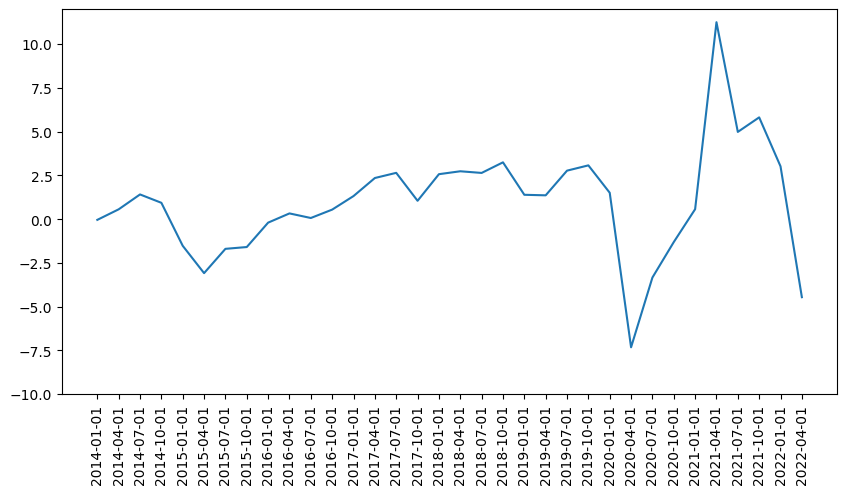

In [18]:
plt.figure(figsize=(10,5))
plt.plot(y["date"], y["Real GDP: YoY"])
plt.xticks(rotation=90)
plt.ylim(-10, 12);

In [59]:
X_m = pd.read_excel("Data_Russia_X_2022 10 20.xlsx", sheet_name="R_m")
X_q = pd.read_excel("Data_Russia_X_2022 10 20.xlsx", sheet_name="R_q")

X_m = assemble_date(X_m[X_m["year"] >= 2014].copy(), q=False)
X_q = assemble_date(X_q[X_q["year"] >= 2014].copy())

In [60]:
print(len(X_m), len(X_q), len(y))

114 34 34


In [61]:
print(y["date"].min(), y["date"].max())
print(X_q["date"].min(), X_q["date"].max())

2014-01-01 2022-04-01
2014-01-01 2022-04-01


In [18]:
X_m.head()

,year,m,Industry: YoY,Mining: YoY,Production: YoY,Energy: YoY,Agriculture: YoY,Construction: YoY,House: YoY,Transport: YoY,Trade: YoY,Unemployment,Inftation,Oil Price: YoY,Exchange Rate USD: YoY,Exchange Rate EUR: YoY,Gas Price: YoY,M2: YoY,Basic_Output:YoY,Leading_index
156,2014,1,-0.2,0.9,0.0,-3.9,2.3,-5.561735,27.777778,3.346595,2.759857,5.6,6.07,-4.915869,17.349317,18.736115,48.038335,13.330828,-0.5,0.108652
157,2014,2,2.1,0.8,3.4,-0.3,2.5,-0.140795,41.379310,1.097219,4.124088,5.6,6.21,-6.616489,17.733508,23.251748,32.214573,12.703785,1.1,0.096033
158,2014,3,1.4,0.6,3.5,-6.6,2.7,-2.695697,25.641026,0.349406,4.309764,5.4,6.92,-1.684365,14.832690,23.241206,8.623260,8.532424,0.4,0.071216
159,2014,4,2.4,1.1,3.9,-1.9,3.5,-1.701276,16.216216,-0.647327,2.861953,5.3,7.33,4.777180,14.203455,21.229187,10.868064,9.138660,0.6,0.081207
160,2014,5,2.8,0.9,4.4,-0.5,3.5,-3.919822,35.294118,1.387909,2.271231,4.9,7.59,6.457575,9.971510,15.377105,14.006024,8.325904,0.7,0.088369


In [ ]:
# def simulate(betas, alphas, sigmas, rho, size=1000):
#     errors = np.random.multivariate_normal(
#         mean=[0, 0],
#         cov=[[1, rho * sigmas[0]], [rho * sigmas[0], sigmas[0] ** 2]],
#         size=size,
#     )
#     z = np.random.normal(0, 1, size=size)
#     x = alphas * z + sigmas[1] * errors[0]
#     y = betas * x + errors[1]

### Filardo (1994) Time-Varying Transition Probabilities

This model demonstrates estimation with time-varying transition probabilities. The dataset can be reached at http://econ.korea.ac.kr/~cjkim/MARKOV/data/filardo.prn.

In the above models we have assumed that the transition probabilities are constant across time. Here we allow the probabilities to change with the state of the economy. Otherwise, the model is the same Markov autoregression of Hamilton (1989).

Each period, the regime now transitions according to the following matrix of time-varying transition probabilities:

$$ P(S_t = s_t | S_{t-1} = s_{t-1}) =
\begin{bmatrix}
p_{00,t} & p_{10,t} \\
p_{01,t} & p_{11,t}
\end{bmatrix}
$$

where $p_{ij,t}$ is the probability of transitioning *from* regime $i$, *to* regime $j$ in period $t$, and is defined to be:

$$
p_{ij,t} = \frac{\exp\{ x_{t-1}' \beta_{ij} \}}{1 + \exp\{ x_{t-1}' \beta_{ij} \}}
$$

Instead of estimating the transition probabilities as part of maximum likelihood, the regression coefficients $\beta_{ij}$ are estimated. These coefficients relate the transition probabilities to a vector of pre-determined or exogenous regressors $x_{t-1}$.

In [6]:
dta_filardo

,month,ip,leading,dlip,dlleading,dmdlleading
1948-01-01,4801.0,23.5,37.9,NaN,NaN,NaN
1948-02-01,4802.0,23.5,37.5,0.000000,-1.061018,-1.315793
1948-03-01,4803.0,23.3,37.8,-0.463457,0.796817,0.542042
1948-04-01,4804.0,23.3,38.2,0.000000,1.052641,0.797866
1948-05-01,4805.0,23.7,37.7,0.922987,-1.317542,-1.572317
...,...,...,...,...,...,...
1990-12-01,9012.0,107.2,139.6,-1.020891,-0.071608,-0.326383
1991-01-01,9101.0,106.6,138.8,-0.561274,-0.574714,-0.829489
1991-02-01,9102.0,105.7,140.4,-0.847862,1.146144,0.891369
1991-03-01,9103.0,105.0,141.4,-0.664454,0.709726,0.454951


In [15]:
X_q.columns

Index(['year', 'q', 'Industry: YoY', 'Mining: YoY', 'Production: YoY',
       'Energy: YoY', 'Agriculture: YoY', 'Construction: YoY', 'House: YoY',
       'Transport: YoY', 'Trade: YoY', 'Unemployment', 'Inftation',
       'Oil Price: YoY', 'Exchange Rate USD: YoY', 'Exchange Rate EUR: YoY',
       'IMOEX: YoY', 'IRTS: YoY', 'Gas Price: YoY', 'MIACR', 'MonBase: YoY',
       'M2: YoY', 'Reserve: YoY'],
      dtype='object')

In [16]:
X_m.columns

Index(['year', 'm', 'Industry: YoY', 'Mining: YoY', 'Production: YoY',
       'Energy: YoY', 'Agriculture: YoY', 'Construction: YoY', 'House: YoY',
       'Transport: YoY', 'Trade: YoY', 'Unemployment', 'Inftation',
       'Oil Price: YoY', 'Exchange Rate USD: YoY', 'Exchange Rate EUR: YoY',
       'Gas Price: YoY', 'M2: YoY', 'Basic_Output:YoY', 'Leading_index'],
      dtype='object')

<Axes: title={'center': 'Leading indicator'}>

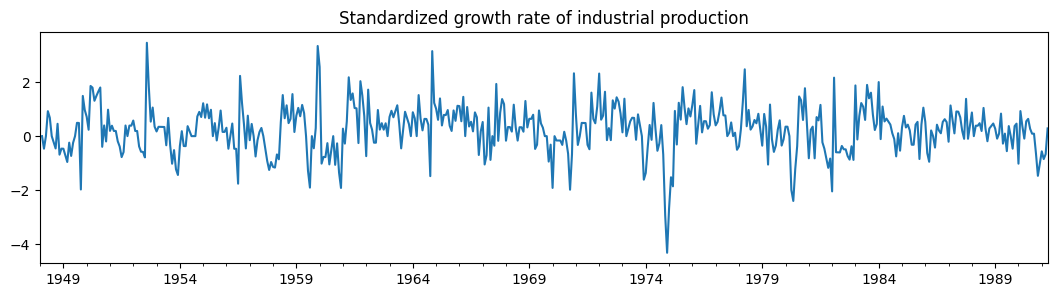

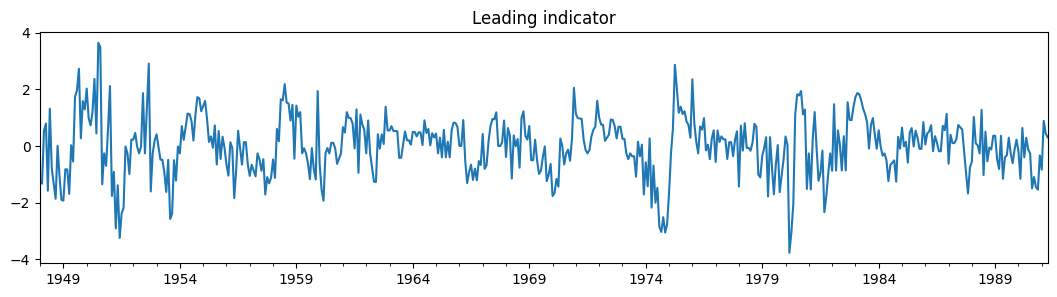

In [62]:
# Get the dataset
filardo = requests.get("http://econ.korea.ac.kr/~cjkim/MARKOV/data/filardo.prn").content
dta_filardo = pd.read_table(
    BytesIO(filardo), sep=" +", header=None, skipfooter=1, engine="python"
)
dta_filardo.columns = ["month", "ip", "leading"]
dta_filardo.index = pd.date_range("1948-01-01", "1991-04-01", freq="MS")

dta_filardo["dlip"] = np.log(dta_filardo["ip"]).diff() * 100
# Deflated pre-1960 observations by ratio of std. devs.
# See hmt_tvp.opt or Filardo (1994) p. 302
std_ratio = (
    dta_filardo["dlip"]["1960-01-01":].std() / dta_filardo["dlip"][:"1959-12-01"].std()
)
dta_filardo["dlip"][:"1959-12-01"] = dta_filardo["dlip"][:"1959-12-01"] * std_ratio

dta_filardo["dlleading"] = np.log(dta_filardo["leading"]).diff() * 100
dta_filardo["dmdlleading"] = dta_filardo["dlleading"] - dta_filardo["dlleading"].mean()

# Plot the data
dta_filardo["dlip"].plot(
    title="Standardized growth rate of industrial production", figsize=(13, 3)
)
plt.figure()
dta_filardo["dmdlleading"].plot(title="Leading indicator", figsize=(13, 3))

The time-varying transition probabilities are specified by the `exog_tvtp` parameter.

Here we demonstrate another feature of model fitting - the use of a random search for MLE starting parameters. Because Markov switching models are often characterized by many local maxima of the likelihood function, performing an initial optimization step can be helpful to find the best parameters.

Below, we specify that 20 random perturbations from the starting parameter vector are examined and the best one used as the actual starting parameters. Because of the random nature of the search, we seed the random number generator beforehand to allow replication of the result.

https://github.com/ljyflores/bayes-for-markov-switching/blob/main/utils.py#L241

In [79]:
dta_filardo = dta_hamilton.copy()

In [33]:
y.columns

Index(['year', 'q', 'Real GDP: YoY', 'Households Consumption: YoY',
       'Government Consumption: YoY', 'Non-commercial Consumption: YoY',
       'Gross Capital Formation: YoY', 'Exports: YoY', 'Imports: YoY', 'date'],
      dtype='object')

In [63]:
len(y)

34

In [74]:
X_q

,year,q,Industry: YoY,Mining: YoY,Production: YoY,Energy: YoY,Agriculture: YoY,Construction: YoY,House: YoY,Transport: YoY,...,Exchange Rate USD: YoY,Exchange Rate EUR: YoY,IMOEX: YoY,IRTS: YoY,Gas Price: YoY,MIACR,MonBase: YoY,M2: YoY,Reserve: YoY,date
52,2014,1,1.100000,0.766667,2.300000,-3.600000,2.500000,-2.745849,30.769231,1.609932,...,16.624877,21.728292,-4.538206,-17.809504,28.334409,6.633333,9.258361,11.496880,-6.787492,2014-01-01
53,2014,2,1.866667,0.933333,2.866667,-1.066667,3.333333,-1.426217,29.508197,1.183194,...,8.905400,14.518590,3.637271,-4.896514,16.195762,8.103333,6.638056,8.006583,-9.432990,2014-04-01
54,2014,3,1.433333,1.133333,1.800000,0.400000,9.966667,-0.686366,16.770186,-0.998323,...,13.767895,11.586806,-0.282400,-12.255794,13.601587,8.000000,8.275069,6.469441,-10.152043,2014-07-01
55,2014,4,2.133333,2.466667,1.566667,4.400000,-2.266667,1.002340,3.144654,-2.185752,...,52.041233,37.378930,-1.666355,-33.972095,-7.777306,11.306667,8.168989,3.718350,-20.428870,2014-10-01
56,2015,1,-0.433333,0.666667,-1.600000,0.100000,2.800000,7.397680,36.764706,-1.560776,...,76.350720,43.460751,17.907906,-33.733749,-42.074266,15.660000,4.655160,4.174228,-26.081807,2015-01-01
57,2015,2,-4.933333,-0.866667,-7.366667,-0.200000,1.933333,0.756144,1.898734,-2.752367,...,53.925243,23.651918,17.503239,-23.037933,-40.476190,13.230000,0.007036,6.245012,-24.222027,2015-04-01
58,2015,3,-4.233333,0.600000,-6.433333,-1.366667,0.800000,-1.833197,-5.851064,1.306873,...,71.093262,46.286182,20.369138,-29.750008,-34.073335,11.176667,1.218959,6.245031,-21.105580,2015-07-01
59,2015,4,-3.866667,0.466667,-5.766667,-4.466667,3.900000,6.045036,0.304878,3.981086,...,36.597973,19.767883,18.674470,-14.239503,-36.470046,11.213333,-0.722292,9.277226,-10.558831,2015-10-01
60,2016,1,-0.733333,3.466667,-3.133333,0.166667,3.566667,-1.385775,-16.129032,1.457399,...,15.482879,14.868916,9.207525,-4.935571,-26.001240,10.933333,9.651338,10.374380,4.238402,2016-01-01
61,2016,2,0.966667,1.600000,0.833333,-0.633333,3.266667,-4.697648,-1.242236,1.030675,...,21.524440,23.630487,15.974500,-5.168054,-10.151976,10.810000,12.404497,11.682849,9.088971,2016-04-01


In [72]:
mod_filardo = sm.tsa.MarkovAutoregression(
    endog=y["Real GDP: YoY"][1:],
    exog=X_q.drop(columns=['year', 'q', 'date']).iloc[1:],
    k_regimes=2,
    order=4,
    switching_ar=False,
    exog_tvtp=sm.add_constant(X_q.drop(columns=['year', 'q', 'date']).iloc[1:]),
)

np.random.seed(12345)
res_filardo = mod_filardo.fit(search_reps=20)

/Users/ruaroe2/.pyenv/versions/3.10.8/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ruaroe2/.pyenv/versions/3.10.8/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/ruaroe2/.pyenv/versions/3.10.8/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [73]:
res_filardo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:            Real GDP: YoY   No. Observations:                   29
Model:             MarkovAutoregression   Log Likelihood                     nan
Date:                  Fri, 26 Apr 2024   AIC                                nan
Time:                          11:50:11   BIC                                nan
Sample:                               0   HQIC                               nan
                                   - 29                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const              -0        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9573        nan        nan        nan         nan         nan
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.8264        nan        nan        nan         nan         nan
x2             0.6256        nan        nan        nan         nan         nan
x3             0.4264        nan        nan        nan         nan         nan
x4             0.0958        nan        nan        nan         nan         nan
x5             0.0563        nan        nan        nan         nan         nan
x6             0.1713        nan        nan        nan         nan         nan
x7            -0.0075        nan        nan        nan         nan         nan
x8            -0.2838        nan        nan        nan         nan         nan
x9             0.0392        nan        nan        nan         nan         nan
x10           -0.4671        nan        nan        nan         nan         nan
x11           -0.1728        nan        nan        nan         nan         nan
x12            0.0099        nan        nan        nan         nan         nan
x13           -0.0566        nan        nan        nan         nan         nan
x14            0.0946        nan        nan        nan         nan         nan
x15            0.0759        nan        nan        nan         nan         nan
x16           -0.0208        nan        nan        nan         nan         nan
x17            0.0033        nan        nan        nan         nan         nan
x18            0.2804        nan        nan        nan         nan         nan
x19           -0.0919        nan        nan        nan         nan         nan
x20            0.0829        nan        nan        nan         nan         nan
x21            0.0300        nan        nan        nan         nan         nan
sigma2         0.0119        nan        nan        nan         nan         nan
ar.L1         -0.1453        nan        nan        nan         nan         nan
ar.L2         -0.3347        nan        nan        nan         nan         nan
ar.L3         -0.0443        nan        nan        nan         nan         nan
ar.L4         -0.0244        nan        nan        nan         nan         nan
                           Regime transition parameters        

Below we plot the smoothed probability of the economy operating in a low-production state, and again include the NBER recessions for comparison.

[Text(0.5, 1.0, 'Smoothed probability of a low-production state')]

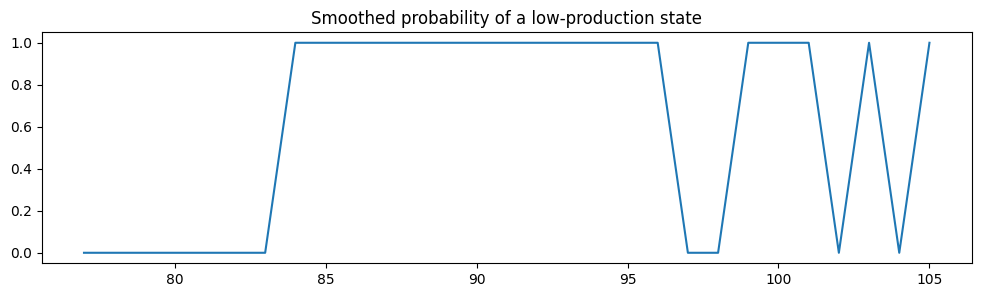

In [70]:
fig, ax = plt.subplots(figsize=(12, 3))

ax.plot(res_filardo.smoothed_marginal_probabilities[0])
# ax.set_xlim(dta_filardo.index[6], dta_filardo.index[-1])
ax.set(title="Smoothed probability of a low-production state")

Using the time-varying transition probabilities, we can see how the expected duration of a low-production state changes over time:


<Axes: title={'center': 'Expected duration of a low-production state'}>

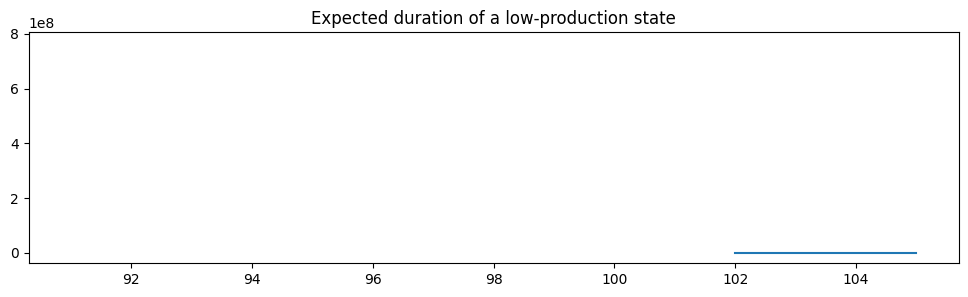

In [71]:
res_filardo.expected_durations[0].plot(
    title="Expected duration of a low-production state", figsize=(12, 3)
)

During recessions, the expected duration of a low-production state is much higher than in an expansion.